In [ ]:
#!pip install torchgeo
#!pip install fastai==1.0.61

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import os
import torch.nn as nn
import zipfile

from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
naip_zip_fn='/content/gdrive/MyDrive/dataset/naip_imgs4SytleGAN/patches.zip'
naip_unzip_fn=r'/content/naip'

#zip_ref = zipfile.ZipFile(naip_zip_fn, 'r')
#zip_ref.extractall(naip_unzip_fn)
#zip_ref.close()

In [2]:
def get_data(bs, size, path, num_workers, noise_size=512):
    return (GANItemList.from_folder(path, noise_sz=noise_size)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs, num_workers=num_workers)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [3]:
naip_unzip_fn=r'I:\data\NAIP4StyleGAN'

workers=4

data_4 = get_data(256, 4, os.path.join(naip_unzip_fn,'patches_4'), workers)
data_8 = get_data(256, 8,  os.path.join(naip_unzip_fn,'patches_8'), workers)
data_16 = get_data(128, 16, os.path.join(naip_unzip_fn,'patches_16'), workers)
data_32 = get_data(128, 32, os.path.join(naip_unzip_fn,'patches_32'), workers)
data_64 = get_data(48, 64, os.path.join(naip_unzip_fn,'patches_64'), workers)
data_128 = get_data(22, 128,  os.path.join(naip_unzip_fn,'patches_128'), workers)
data_256 = get_data(10, 256,  os.path.join(naip_unzip_fn,'patches_256'), workers)
data_512 = get_data(4, 512,  os.path.join(naip_unzip_fn,'naip_512'), workers)

In [4]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * math.sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

In [5]:
class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)

In [6]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        padding,
        kernel_size2=None,
        padding2=None,
        pixel_norm=True,
        spectral_norm=False,
    ):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        self.conv = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel1, padding=pad1),
            nn.LeakyReLU(0.2),
            EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
            nn.LeakyReLU(0.2),
        )

    def forward(self, input):
        out = self.conv(input)

        return out

In [7]:
class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

        self.style.linear.bias.data[:in_channel] = 1
        self.style.linear.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out

In [8]:
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise

In [9]:
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out

In [10]:
class StyledConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size=3,
        padding=1,
        style_dim=512,
        initial=False,
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            self.conv1 = EqualConv2d(
                in_channel, out_channel, kernel_size, padding=padding
            )

        self.noise1 = equal_lr(NoiseInjection(out_channel))
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel, out_channel, kernel_size, padding=padding)
        self.noise2 = equal_lr(NoiseInjection(out_channel))
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, input, style, noise):
        out = self.conv1(input)
        out = self.noise1(out, noise)
        out = self.adain1(out, style)
        out = self.lrelu1(out)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.adain2(out, style)
        out = self.lrelu2(out)

        return out

In [11]:
class Generator(nn.Module):
    def __init__(self, code_dim):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                StyledConvBlock(512, 512, 3, 1, initial=True), # 4x4
                StyledConvBlock(512, 512, 3, 1), # 8x8
                StyledConvBlock(512, 512, 3, 1), # 16x16
                StyledConvBlock(512, 512, 3, 1), # 32x32
                StyledConvBlock(512, 256, 3, 1), # 64x64
                StyledConvBlock(256, 128, 3, 1), # 128x128
                StyledConvBlock(128, 64, 3, 1), # 256x256
                StyledConvBlock(64, 32, 3, 1), # 512x512
                StyledConvBlock(32, 16, 3, 1), # 1024x1024
            ]
        )

        self.to_rgb = nn.ModuleList(
            [
                EqualConv2d(512, 3, 1), # 4x4
                EqualConv2d(512, 3, 1), # 8x8
                EqualConv2d(512, 3, 1), # 16x16
                EqualConv2d(512, 3, 1), # 32x32
                EqualConv2d(256, 3, 1), # 64x64
                EqualConv2d(128, 3, 1), # 128x128
                EqualConv2d(64, 3, 1), # 256x256
                EqualConv2d(32, 3, 1), # 512x512
                EqualConv2d(16, 3, 1), # 1024x1024
            ]
        )
        
    def forward(self, style, noise, step=0, alpha=-1, mixing_range=(-1, -1)):
        out = noise[0]

        if len(style) < 2:
            inject_index = [len(self.progression) + 1]

        else:
            inject_index = random.sample(list(range(step)), len(style) - 1)

        crossover = 0

        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):
            if mixing_range == (-1, -1):
                if crossover < len(inject_index) and i > inject_index[crossover]:
                    crossover = min(crossover + 1, len(style))

                style_step = style[crossover]

            else:
                if mixing_range[0] <= i <= mixing_range[1]:
                    style_step = style[1]

                else:
                    style_step = style[0]

            if i > 0 and step > 0:
                upsample = F.interpolate(
                    out, scale_factor=2, mode='bilinear', align_corners=False
                )
                out = conv(upsample, style_step, noise[i])

            else:
                out = conv(out, style_step, noise[i])

            if i == step:
                out = to_rgb(out)

                if i > 0 and alpha > 0:
                    skip_rgb = self.to_rgb[i - 1](upsample)
                    out = alpha * skip_rgb + (1 - alpha) * out

                break

        return out

In [12]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

In [13]:
class StyledGenerator(nn.Module):
    def __init__(self, code_dim=512, n_mlp=8):
        super().__init__()

        self.generator = Generator(code_dim)

        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(EqualLinear(code_dim, code_dim))
            layers.append(nn.LeakyReLU(0.2))

        self.style = nn.Sequential(*layers)
        
        self.step = 0
        self.alpha = 0

    def forward(self, input, noise=None, mean_style=None, style_weight=0, mixing_range=(-1, -1), mixing=True):
        
        bs, ch, _, _ = input.shape
        input = input.view(bs, ch)
        
        if self.step < 1:
            mixing=False
        
        if mixing and random.random() < 0.9:
            shuffle = torch.randperm(input.size(0)).to(input.device)
            input = [input, input[shuffle]]
        else:
            input = [input]  
        
        styles = []

        for i in input:
            styles.append(self.style(i))

        batch = input[0].shape[0]

        if noise is None:
            noise = []

            for i in range(self.step + 1):
                size = 4 * 2 ** i
                noise.append(torch.randn(batch, 1, size, size, device=input[0].device))

        if mean_style is not None:
            styles_norm = []

            for style in styles:
                styles_norm.append(mean_style + style_weight * (style - mean_style))

            styles = styles_norm

        return self.generator(styles, noise, self.step, self.alpha, mixing_range=mixing_range)

    def mean_style(self, input):
        style = self.style(input).mean(0, keepdim=True)

        return style
        
    def grow_model(self, step=None, alpha=None):
        if step:
            self.step = step
        else:
            self.step += 1
            
        if alpha is not None:
            self.alpha = alpha
        else:
            self.alpha = 1

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                ConvBlock(16, 32, 3, 1),
                ConvBlock(32, 64, 3, 1),
                ConvBlock(64, 128, 3, 1),
                ConvBlock(128, 256, 3, 1),
                ConvBlock(256, 512, 3, 1),
                ConvBlock(512, 512, 3, 1),
                ConvBlock(512, 512, 3, 1),
                ConvBlock(512, 512, 3, 1),
                ConvBlock(513, 512, 3, 1, 4, 0),
            ]
        )

        self.from_rgb = nn.ModuleList(
            [
                EqualConv2d(3, 16, 1),
                EqualConv2d(3, 32, 1),
                EqualConv2d(3, 64, 1),
                EqualConv2d(3, 128, 1),
                EqualConv2d(3, 256, 1),
                EqualConv2d(3, 512, 1),
                EqualConv2d(3, 512, 1),
                EqualConv2d(3, 512, 1),
                EqualConv2d(3, 512, 1),
            ]
        )


        self.n_layer = len(self.progression)

        self.linear = EqualLinear(512, 1)
        
        self.step = 0
        self.alpha = 0

    def forward(self, input, actual=False):
        if actual:
            for i in range(self.step, -1, -1):
                index = self.n_layer - i - 1

                if i == self.step:
                    out = self.from_rgb[index](input)

                if i == 0:
                    out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                    mean_std = out_std.mean()
                    mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                    out = torch.cat([out, mean_std], 1)

                out = self.progression[index](out)

                if i > 0:
                    out = F.interpolate(
                        out, scale_factor=0.5, mode='bilinear', align_corners=False
                    )

                    if i == self.step and self.alpha > 0:  #0 <= alpha < 1:
                        skip_rgb = self.from_rgb[index + 1](input)
                        skip_rgb = F.interpolate(
                            skip_rgb, scale_factor=0.5, mode='bilinear', align_corners=False
                        )

                        out = self.alpha * skip_rgb + (1 - self.alpha) * out

            out = out.squeeze(2).squeeze(2)
            out = self.linear(out)

            return (out, input)
        else:
            return (None, input)
    
    def grow_model(self, step=None, alpha=None):
        if step:
            self.step = step
        else:
            self.step += 1
            
        if alpha is not None:
            self.alpha = alpha
        else:
            self.alpha = 1

In [15]:
class StyleCriticLoss_R1(nn.Module):
    
    def forward(self, fake, gradient_predict):
        real_predict = F.softplus(-gradient_predict[0]).mean()
        
        grad_real = torch.autograd.grad(outputs=gradient_predict[0].sum(), inputs=gradient_predict[1], create_graph=True)[0]
        grad_penalty = grad_real.view(grad_real.size(0), -1).norm(2, dim=1).pow(2).mean()
        grad_penalty = 10 / 2 * grad_penalty
        
        fake_predict = F.softplus(fake).mean()
        
        loss = real_predict + fake_predict + grad_penalty
        
        return loss
    
class StyleGenLoss_R1(nn.Module):
    
    def forward(self, fake_pred, *args):
        return F.softplus(-fake_pred).mean()

In [16]:
class GANLossGradient(GANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG:Callable, loss_funcC:Callable, gan_model:GANModule, grad_scale=10):
        super().__init__()
        self.loss_funcG,self.loss_funcC,self.gan_model = loss_funcG,loss_funcC,gan_model
        self.grad_scale = grad_scale

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        fake_pred = self.gan_model.critic(output, actual=True)[0]
        return self.loss_funcG(fake_pred, target, output)

    def critic(self, real_pred, input):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.loss_funcD`."
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake_pred = self.gan_model.critic(fake, actual=True)
        
        real_pred[1].requires_grad = True
        gradient_predict = self.gan_model.critic(real_pred[1], actual=True)
        
        return self.loss_funcC(fake_pred[0], gradient_predict)  

In [17]:
class AlphaDecay(LearnerCallback):
    
    def __init__(self, learn, end_batch):
        super().__init__(learn)
        self.end_batch = end_batch
        self.initial_alpha = self.learn.model.generator.alpha
        
    def on_batch_begin(self, iteration, **kwargs):
        if self.learn.model.generator.alpha > 0:
            self.learn.model.generator.alpha = self.initial_alpha - iteration / self.end_batch
            self.learn.model.critic.alpha = self.initial_alpha - iteration / self.end_batch

In [18]:
class StyleGANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, alpha_batch=10, **learn_kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLossGradient(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=5, n_gen=1))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = GANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)
        self.callback_fns.append(partial(AlphaDecay, end_batch=alpha_batch))
    
    @classmethod
    def stylegan_r1(cls, data:DataBunch, generator:nn.Module, critic:nn.Module, 
             switcher:Callback=None, clip:float=None, **learn_kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        return cls(data, generator, critic, StyleGenLoss_R1(), 
                       StyleCriticLoss_R1(), switcher=switcher, clip=clip, **learn_kwargs)

    def grow_model(self, data, step=None, alpha=None, alpha_batch=None):
        self.model.generator.grow_model(step=step, alpha=alpha)
        self.model.critic.grow_model(step=step, alpha=alpha)
        self.data = data
        
        if alpha_batch is not None:
            self.callback_fns[-1] = partial(AlphaDecay, end_batch=alpha_batch)

In [109]:
g = StyledGenerator()
d = Discriminator()

In [110]:
learn = StyleGANLearner.stylegan_r1(data_4, g, d, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0., alpha_batch=6000, clip=None,
                              switcher=partial(FixedGANSwitcher, n_crit=2, n_gen=1))

In [111]:
def style_split(model):
    groups = [[model.generator.style]]
    groups += [[model.generator.generator, model.critic]]
    return groups

In [112]:
learn.split(style_split);

In [113]:
pretrained_model_fn=r'C:\Users\richi\omen_richiebao\omen_github\models_trained\naip_styleGAN_32'
learn=learn.load(pretrained_model_fn)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.146563,#na#,0.674979,1.387089,01:18


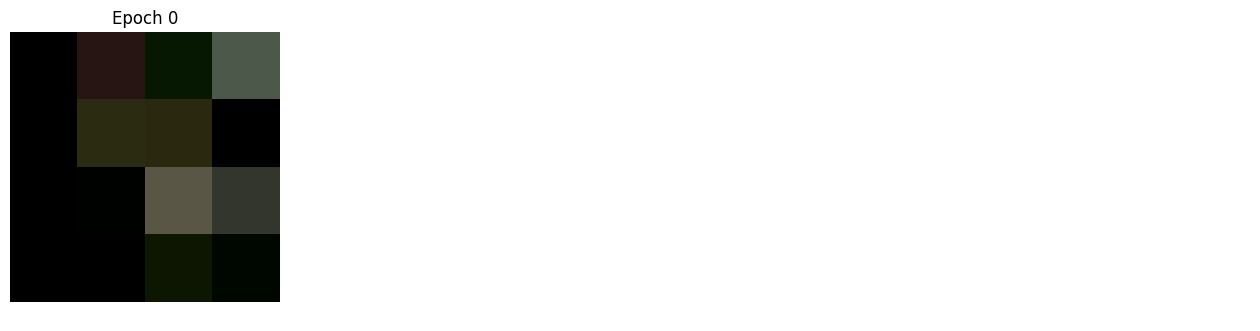

In [115]:
learn.fit(1, 1e-3)

In [117]:
# 8x8
learn.grow_model(data_8, alpha_batch=2600)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.152452,#na#,0.698992,1.385895,01:14


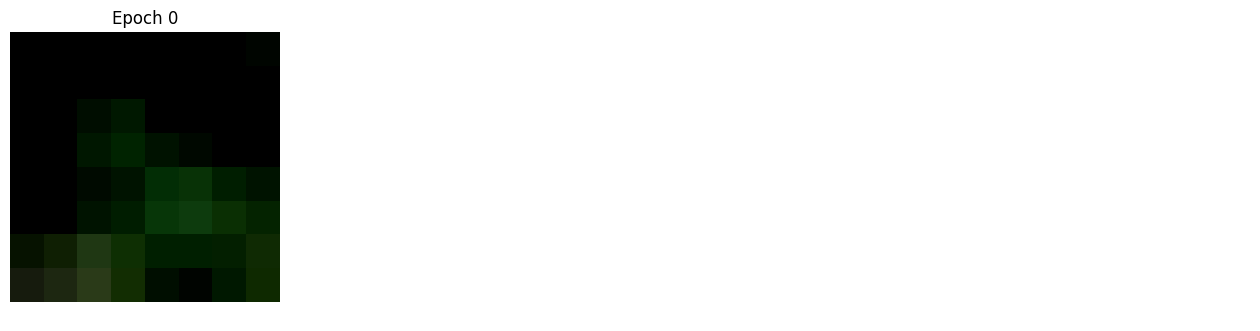

In [118]:
learn.fit(1, 1e-3)

In [120]:
# 16x16
learn.grow_model(data_16, alpha_batch=5100)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.155171,#na#,0.767090,1.366041,05:23


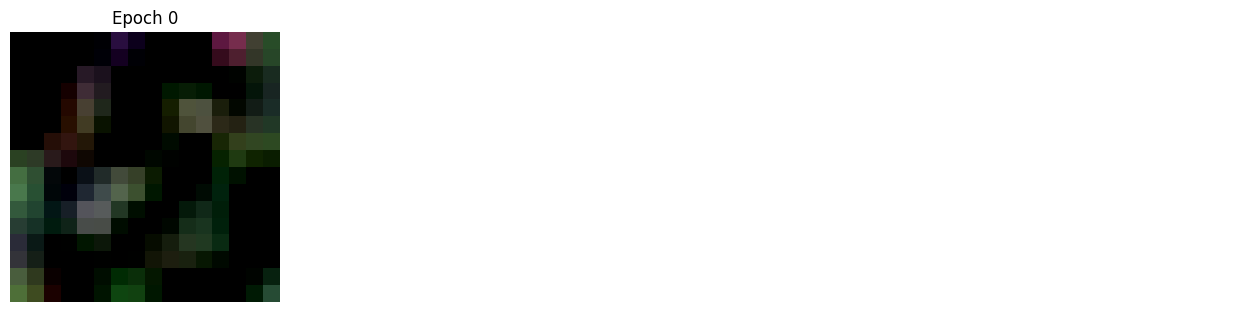

In [121]:
learn.fit(1, [1e-4, 1e-3])

In [123]:
# 32x32
learn.grow_model(data_32, alpha_batch=5100)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.126482,#na#,0.869020,1.304149,08:58


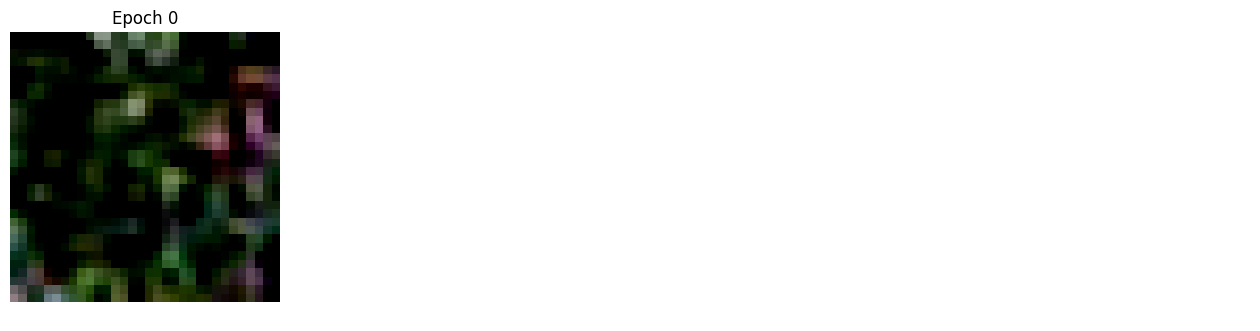

In [124]:
learn.fit(1, [1e-4, 1e-3])

In [36]:
model_save_root=r'/content/gdrive/MyDrive/pretrained_model'
learn.save(os.path.join(model_save_root,'naip_styleGAN_32'))
#learn.save_encoder(os.path.join(model_save_root,'naip_styleGAN_32_encoder'))

In [127]:
# 64x64
learn.grow_model(data_64, alpha_batch=13750)

In [128]:
learn.fit(1, [1e-4, 1e-3])

epoch,train_loss,valid_loss,gen_loss,disc_loss,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 8.00 GiB total capacity; 6.20 GiB already allocated; 0 bytes free; 6.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learn.save(os.path.join(model_save_root,'naip_styleGAN_64'))

In [ ]:
# 128x128
learn.grow_model(data_128, alpha_batch=30000)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,4.483214,#na#,14.513872,0.317239,16:19
1,3.490206,#na#,10.490265,0.581500,16:24


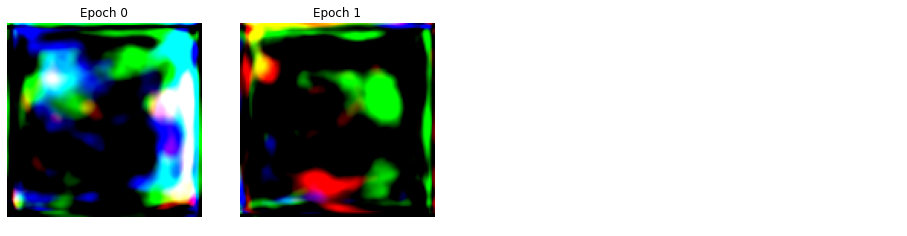

In [ ]:
learn.fit(2, [1e-4, 1e-3])

In [ ]:
# 256x256
learn.grow_model(data_256, alpha_batch=66000)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,2.035564,#na#,6.515068,0.116472,00:08


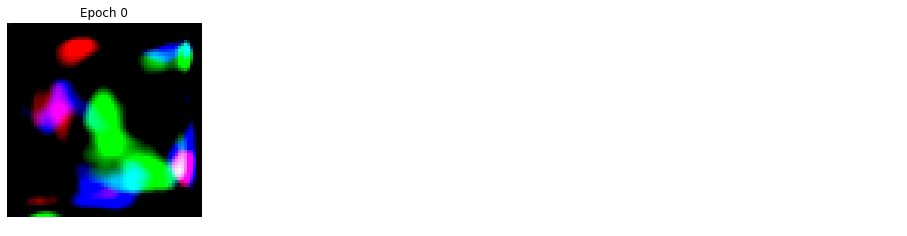

In [ ]:
learn.fit(1, [1e-5, 1e-3])

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,2.155932,#na#,6.998212,0.106484,00:08


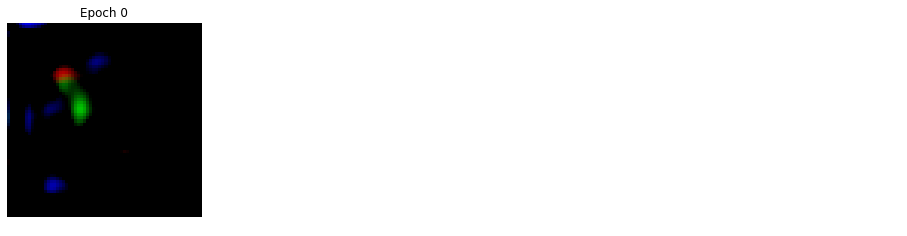

In [ ]:
learn.fit(1, [1e-5, 1e-3])

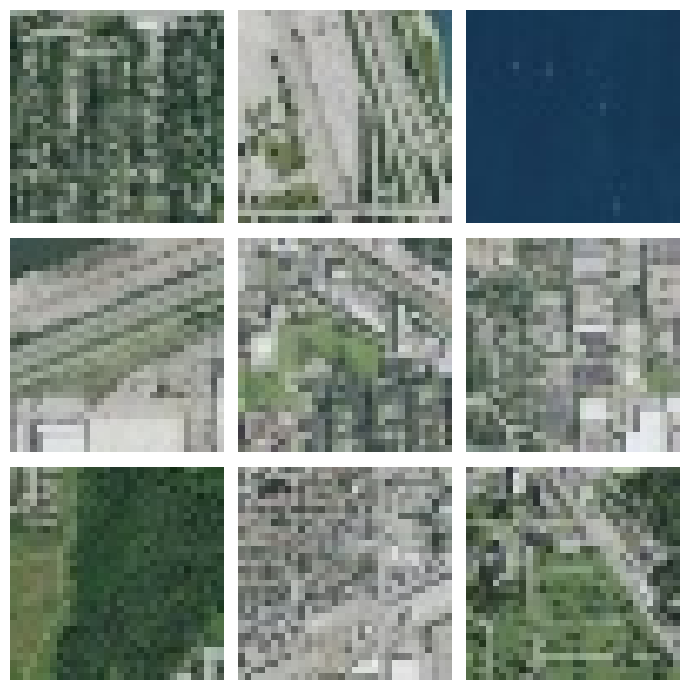

In [49]:
data_32.show_batch(rows=3,figsize=(7,7))

In [51]:
ngpu=1
device=torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu") # Decide which device we want to run on
device

device(type='cuda', index=0)

In [84]:
g = StyledGenerator()
d = Discriminator()

In [85]:
learn = StyleGANLearner.stylegan_r1(data_32, g, d, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0., alpha_batch=6000, clip=None,
                              switcher=partial(FixedGANSwitcher, n_crit=2, n_gen=1))

In [86]:
def style_split(model):
    groups = [[model.generator.style]]
    groups += [[model.generator.generator, model.critic]]
    return groups

In [87]:
learn.split(style_split);

In [88]:
pretrained_model_fn=r'C:\Users\richi\omen_richiebao\omen_github\models_trained\naip_styleGAN_32'
learn=learn.load(pretrained_model_fn)

In [105]:
latents = torch.randn(1,3,32,32, device=device)
latents.shape

torch.Size([1, 3, 32, 32])

In [90]:
fixed_noise = torch.randn(1,3,32,32,  device=device)
print(fixed_noise.shape)

torch.Size([1, 3, 32, 32])


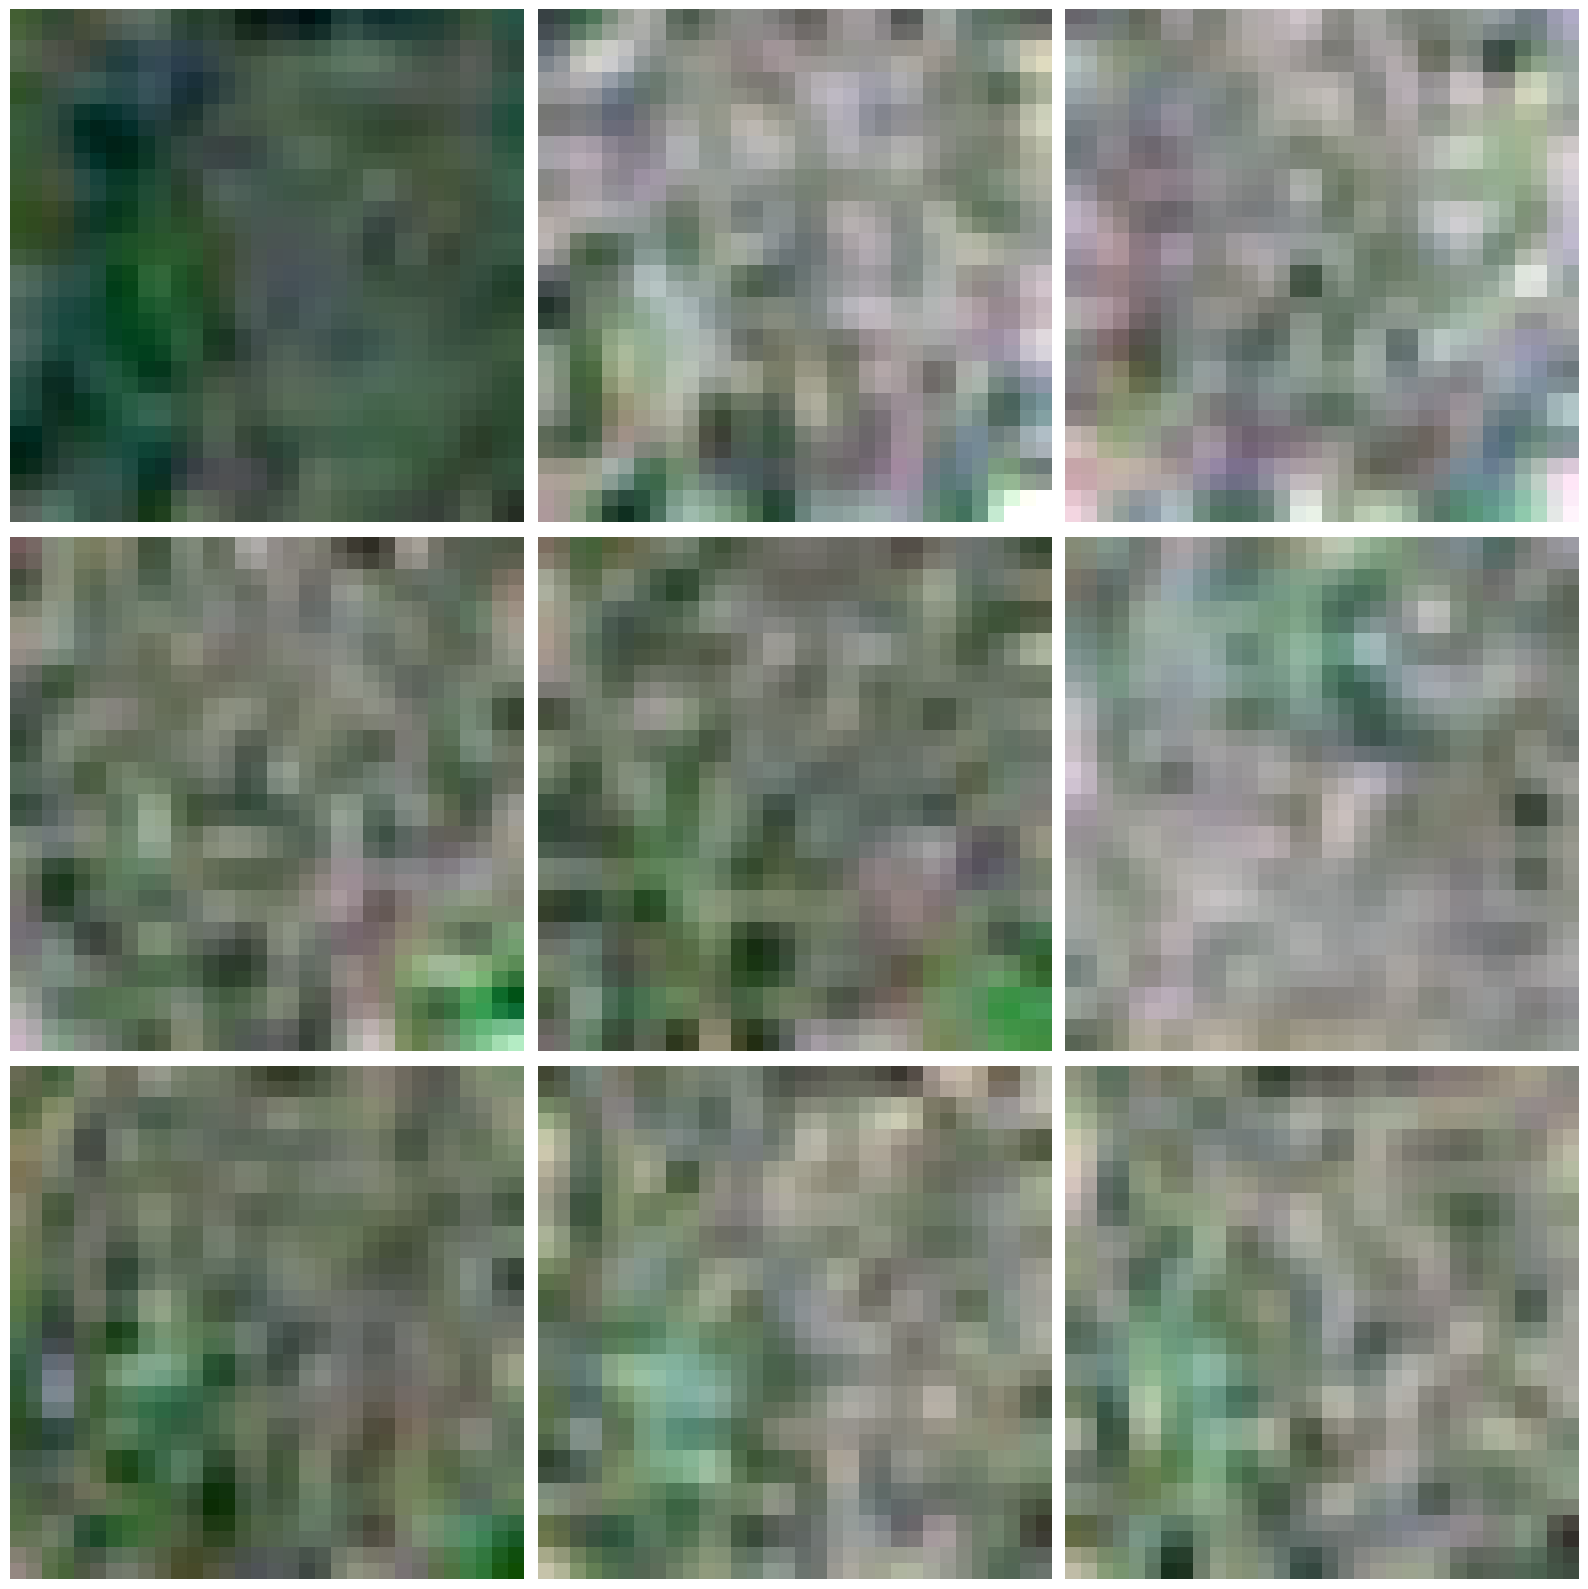

In [126]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=3, figsize=(16,16))

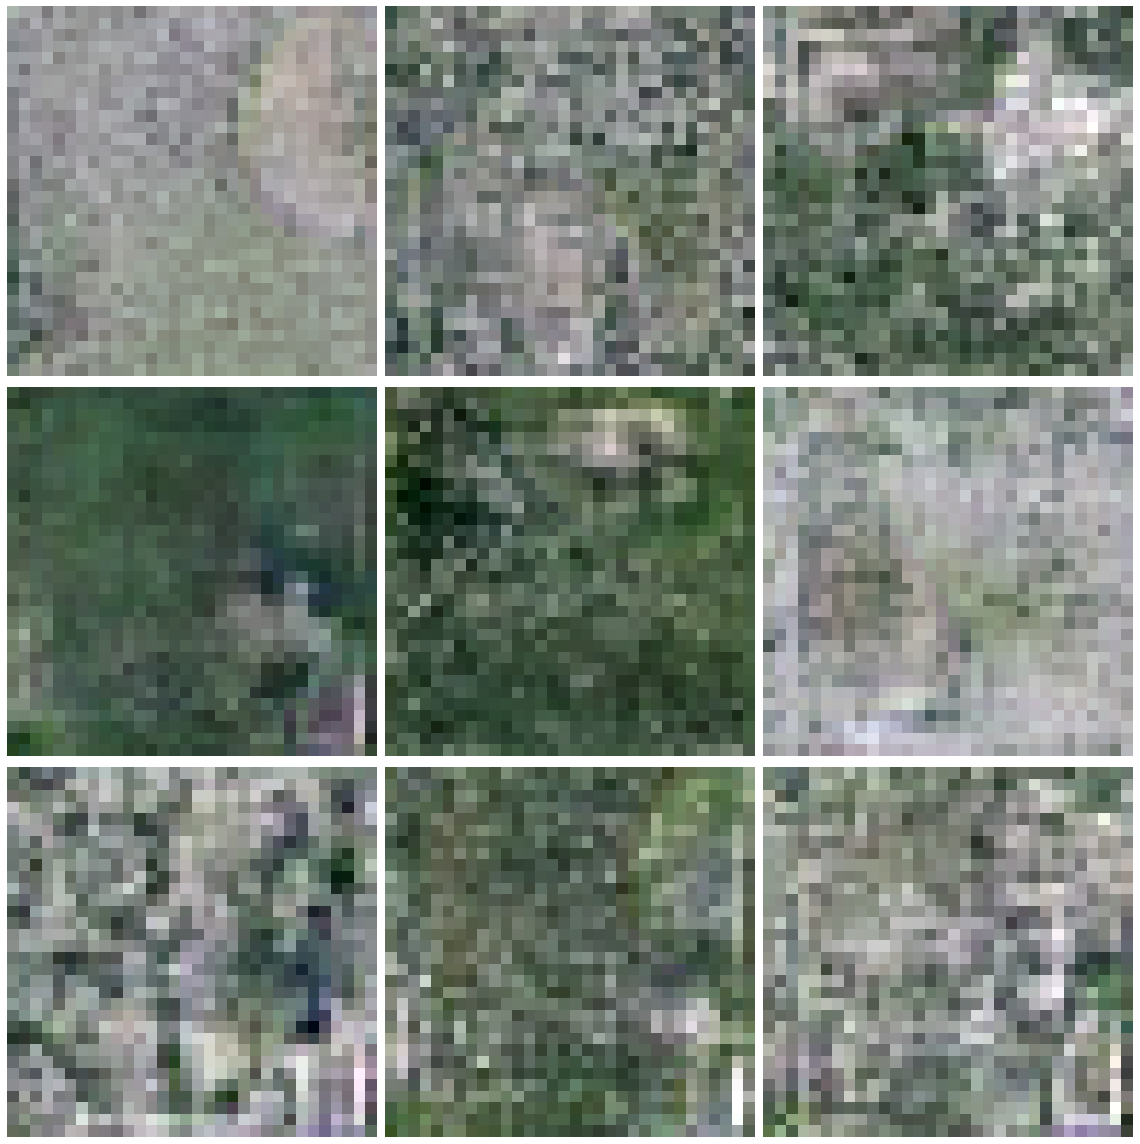

In [37]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=3, figsize=(16,16))

In [27]:
#!zip -r /content/file.zip /content/naip_imgs

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>